# 参考サイト  
[コンペサイト アップル 引越し需要予測](https://signate.jp/competitions/269/data)  
[SIGNATE SOTA アップル 引越し需要予測 備忘録](https://zenn.dev/tremendous1192/articles/ea6e73359ee764)  


# 前処理

In [12]:
import polars as pl
import polars.selectors as cs
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_cols(100)
import numpy as np

import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

from datetime import date
import matplotlib.dates as mdates

import jpholiday

from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV, train_test_split

In [13]:
# EDA2までの処理をまとめたもの

# データを読み込む
train = pl.read_csv("../data/input/train.csv")
test = pl.read_csv("../data/input/test.csv")
sample_submit = pl.read_csv("../data/input/sample_submit.csv", has_header = False)

# IDと日時を分散する
train = train.insert_column(0, train["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))
test = test.insert_column(0, test["datetime"].alias("id")).with_columns(pl.col("datetime").str.strptime(dtype = pl.Date))

# 休業日(close = 1)(と、お盆だけど休業していなくて結局引っ越し数0だった日)を分離する
train = train.filter(
    (pl.col("close") != 1)
    & (pl.col("id") != "2010-08-18")
    & (pl.col("id") != "2011-08-14")
)
test_close = test.filter(pl.col("close") == 1)[["id"]]
test_close = test_close.with_columns(pl.Series("y", [0.0] * len(test_close)))
test = test.filter(pl.col("close") != 1)

# 目的変数を対数変換する
train = train.insert_column(3, train["y"].log().alias("y_ln"))

# closeをカラムごと削除
train = train.drop("close")
test = test.drop("close")

# 2010年は料金区分に関する情報が欠損しているので学習から削除
train = train.filter(pl.col("datetime") >= date(2011, 1, 1))

## 特徴量を追加

In [ ]:
# 思いつく限りの特徴量を追加
# 今後の運用を考えると、任意の日時について自動でフラグを取得できる必要がある。要改善

# 祝日
holiday_list = []
for pair in jpholiday.between(date(2010, 1, 1), date(2017, 12, 31)):
    # print(pair)
    holiday_list.append(pair[0])

# その他の休日
# GW
# https://9rando.info/j-holiday/gw/2011/
gw_list = [
    date(2011, 4, 29), date(2011, 4, 30), date(2011, 5, 1),
    date(2011, 5, 2),# 有給休暇の可能性
    date(2011, 5, 3), date(2011, 5, 4), date(2011, 5, 5),

    date(2012, 4, 28), date(2012, 4, 29), date(2012, 4, 30), date(2012, 5, 1),
    date(2012, 5, 2),# 有休
    date(2012, 5, 3), date(2012, 5, 4), date(2012, 5, 5), date(2012, 5, 5),

    date(2013, 4, 27), date(2013, 4, 28), date(2013, 4, 29),
    date(2013, 4, 30), date(2013, 5, 1), date(2013, 5, 2),# 有休
    date(2013, 5, 3), date(2013, 5, 4), date(2013, 5, 5), date(2013, 5, 5), date(2013, 5, 6),

    date(2014, 4, 29),
    date(2014, 4, 30), date(2014, 5, 1), date(2014, 5, 2),# 有休
    date(2014, 5, 3), date(2014, 5, 4), date(2014, 5, 5), date(2014, 5, 5), date(2014, 5, 6),

    date(2015, 4, 29),
    date(2015, 4, 30), date(2015, 5, 1),# 有休
    date(2015, 5, 2), date(2015, 5, 3), date(2015, 5, 4), date(2015, 5, 5), date(2015, 5, 5), date(2015, 5, 6),

    date(2016, 4, 29), date(2016, 4, 30), date(2016, 5, 1),
    date(2016, 5, 2),# 有休
    date(2016, 5, 3), date(2016, 5, 4), date(2016, 5, 5),

    date(2017, 4, 29), date(2017, 4, 30),
    date(2017, 5, 1), date(2017, 5, 2),# 有休
    date(2017, 5, 3), date(2017, 5, 4), date(2017, 5, 5), date(2017, 5, 6), date(2017, 5, 7),
]

# お盆
# https://9rando.info/j-holiday/obon/2011/
obon_list = [
    date(2011, 8, 13), date(2011, 8, 14), date(2011, 8, 15), date(2011, 8, 16),
    date(2012, 8, 13), date(2012, 8, 14), date(2012, 8, 15), date(2012, 8, 16),
    date(2013, 8, 13), date(2013, 8, 14), date(2013, 8, 15), date(2013, 8, 16),
    date(2014, 8, 13), date(2014, 8, 14), date(2014, 8, 15), date(2014, 8, 16),
    date(2015, 8, 13), date(2015, 8, 14), date(2015, 8, 15), date(2015, 8, 16),
    date(2016, 8, 13), date(2016, 8, 14), date(2016, 8, 15), date(2016, 8, 16),
    date(2017, 8, 13), date(2017, 8, 14), date(2017, 8, 15), date(2017, 8, 16),
]

# シルバーウィーク
# https://9rando.info/j-holiday/sw/2011/
sw_list = [
    date(2011, 9, 17), date(2011, 9, 18), date(2011, 9, 19),
    date(2011, 9, 20), date(2011, 9, 21), date(2011, 9, 22),# 有休
    date(2011, 9, 23), date(2011, 9, 24), date(2011, 9, 25),

    date(2012, 9, 15), date(2012, 9, 16), date(2012, 9, 17),
    date(2012, 9, 18), date(2012, 9, 19), date(2012, 9, 20), date(2012, 9, 21),# 有休
    date(2012, 9, 22), date(2012, 9, 23), date(2012, 9, 24),

    date(2013, 9, 14),date(2013, 9, 15), date(2013, 9, 16),
    date(2013, 9, 17), date(2013, 9, 18), date(2013, 9, 19), date(2013, 9, 20),# 有休
    date(2013, 9, 21),date(2013, 9, 22), date(2013, 9, 23),

    date(2014, 9, 13), date(2014, 9, 14),date(2014, 9, 15),
    date(2014, 9, 16), date(2014, 9, 17), date(2014, 9, 18), date(2014, 9, 19),# 有休
    date(2014, 9, 20), date(2014, 9, 21),date(2014, 9, 22),

    date(2015, 9, 19), date(2015, 9, 20), date(2015, 9, 21),
    date(2015, 9, 22), date(2015, 9, 23),

    date(2016, 9, 17), date(2016, 9, 18), date(2016, 9, 19),
    date(2016, 9, 20), date(2016, 9, 21),# 有休
    date(2016, 9, 22),

    date(2017, 9, 16), date(2017, 9, 17), date(2017, 9, 18),
    date(2017, 9, 19), date(2017, 9, 20), date(2017, 9, 21), date(2017, 9, 22),# 有休
    date(2017, 9, 23), date(2017, 9, 24),
]

In [15]:
def add_features(df):
    return(
        df
        # 日付の基本要素の追加
        .with_columns([
            # 年、四半期、月
            pl.col("datetime").dt.year().alias("year"),
            pl.col("datetime").dt.quarter().alias("quarter"),        
            pl.col("datetime").dt.month().alias("month"),
            # 年始から数えて何週目か
            pl.col("datetime").dt.week().alias("week"),
            # 年始から数えて何日目か
            pl.col("datetime").dt.ordinal_day().alias("ordinal_day"),
            # その月の何日か
            pl.col("datetime").dt.day().alias("day"),        
            # その月の何週目か
            (pl.col("datetime").dt.day() // 7 + 1).alias("week_of_month"),
            # 曜日(月曜日が1、日曜日が6)
            pl.col("datetime").dt.weekday().alias("day_of_week"),
        ])
        # 四半期はじめ・終わり、月はじめ・終わりのフラグ
        .with_columns([
            pl.when((pl.col("month").is_in([1, 4, 7, 10])) & (pl.col("day") == 1)).then(1).otherwise(0)
            .alias("quarter_start"),
            pl.when((pl.col("month").is_in([3, 6, 9, 12])) & (pl.col("datetime") == pl.col("datetime").dt.month_end())).then(1).otherwise(0)
            .alias("quarter_end"),
            pl.when(pl.col("day") == 1).then(1).otherwise(0)
            .alias("month_start"),
            pl.when(pl.col("datetime") == pl.col("datetime").dt.month_end()).then(1).otherwise(0)
            .alias("month_end"),    
        ])
        # 祝日・休日・土日フラグ
        .with_columns([
            pl.when(pl.col("datetime").is_in(holiday_list)).then(1).otherwise(0)
            .alias("holiday"),
            pl.when(pl.col("datetime").is_in(gw_list)).then(1).otherwise(0)
            .alias("GW"),
            pl.when(pl.col("datetime").is_in(sw_list)).then(1).otherwise(0)
            .alias("SW"),
            pl.when(pl.col("datetime").is_in(obon_list)).then(1).otherwise(0)
            .alias("obon"),
            pl.when(pl.col("datetime").dt.weekday() >= 6).then(1).otherwise(0)
            .alias("sat_sun"),
        ])
        # 価格の和・差・積
        .with_columns([
            (pl.col("price_am") + pl.col("price_pm")).alias("price_sum"),
            (pl.col("price_am") - pl.col("price_pm")).alias("price_difference"),
            # price = -1が欠損、price = 0は最安価格であった。price同士をそのまま乗算しまうと最安値のときに必ず積が0になってしまうので都合が良くない
            # price + 1とすることでこれを回避する。なお、欠損がある場合は積は必ず0となる。これはこれで良いフラグかもしれない？
            ((pl.col("price_am") + 1) * (pl.col("price_pm") + 1)).alias("price_product"),
        ])
    )

train = add_features(train)
test = add_features(test)

del holiday_list, gw_list, sw_list, obon_list

# display(train)
# display(test)

# モデル構築

## prophetによるベースライン作成

In [16]:
# 年を経るごとにyが上昇していくため、yの分布がどんどん右にシフトしていく問題に対処したい
# そこで、prophetによる時系列予測によってyのトレンドを予測し、yのトレンドを除去する

# polarsのdatetime型をpandasのdatetime型に変換する必要がある
# 訓練データ
train_pandas = (
    train
    .select(["datetime", "y_ln"])
    .rename({"datetime": "ds", "y_ln": "y"})
    .to_pandas()
)
# テストデータ
test_pandas = (
    test
    .select(["datetime"])
    .rename({"datetime": "ds"})
    .to_pandas()
)
# 学習
model = Prophet()
model.fit(train_pandas)

# 推定値の算出
forecast_train = pl.Series("y_ln_prophet", model.predict(train_pandas)["yhat"].values)
forecast_test = pl.Series("y_ln_prophet", model.predict(test_pandas)["yhat"].values)

# 推定値をDataFrameにまとめる
train = train.insert_column(4, forecast_train)
test = test.insert_column(3, forecast_test)

# 対数変換した目的変数とProphetによる予測値の差分を計算する
train = train.insert_column(5, (train["y_ln"] - train["y_ln_prophet"]).alias("y_ln_difference"))

# 不要なDataFrameを削除
del train_pandas
del test_pandas

10:17:46 - cmdstanpy - INFO - Chain [1] start processing
10:17:46 - cmdstanpy - INFO - Chain [1] done processing


## 学習と予測

In [17]:
# print(train.columns)

In [18]:
# 機械学習ライブラリと親和性の高いPandasに変換する
train_pandas = train.to_pandas().set_index("id")

# 目的変数と特徴量
target_column = "y_ln_difference"
feature_columns = [
    'client',
    'price_am',
    'price_pm',
    'year',
    'quarter',
    'month',
    'week',
    'ordinal_day',
    'day',
    'week_of_month',
    'day_of_week',
    'quarter_start',
    'quarter_end',
    'month_start',
    'month_end',
    'holiday',
    'GW',
    'SW',
    'obon',
    'sat_sun',
    'price_sum',
    'price_difference',
    'price_product'
]

# 今回は時系列予測なので、訓練データと評価データを分割する際に、時系列の順番を考慮する必要がある
# 今回は、2015年1月1日を境に訓練データと評価データを分割する
# 訓練データと検証データを期間で分割
train_temp = train_pandas[train_pandas["datetime"] < "2015-01-01"]
valid_temp = train_pandas[train_pandas["datetime"] >= "2015-01-01"]

# 説明変数と目的変数を分割
X_train, y_train = train_temp[feature_columns], train_temp[target_column]
X_valid, y_valid = valid_temp[feature_columns], valid_temp[target_column]

# 学習
model = GradientBoostingRegressor(random_state = 1192).fit(X_train, y_train)

# 予測(モデルの予測値をベースラインであるy_ln_prophetに足した後、対数変換を逆変換)
y_pred_train = np.exp(model.predict(X_train) + train_temp["y_ln_prophet"])
y_pred_valid = np.exp(model.predict(X_valid) + valid_temp["y_ln_prophet"])

# 予測精度の確認
print("訓練データの評価関数:", np.round(mean_absolute_error(train_temp["y"], y_pred_train), decimals = 7))# 小数第7位はコンペスコアの有効数字
print("評価データの評価関数:", np.round(mean_absolute_error(valid_temp["y"], y_pred_valid), decimals = 7))

訓練データの評価関数: 4.2906884
評価データの評価関数: 7.2156618


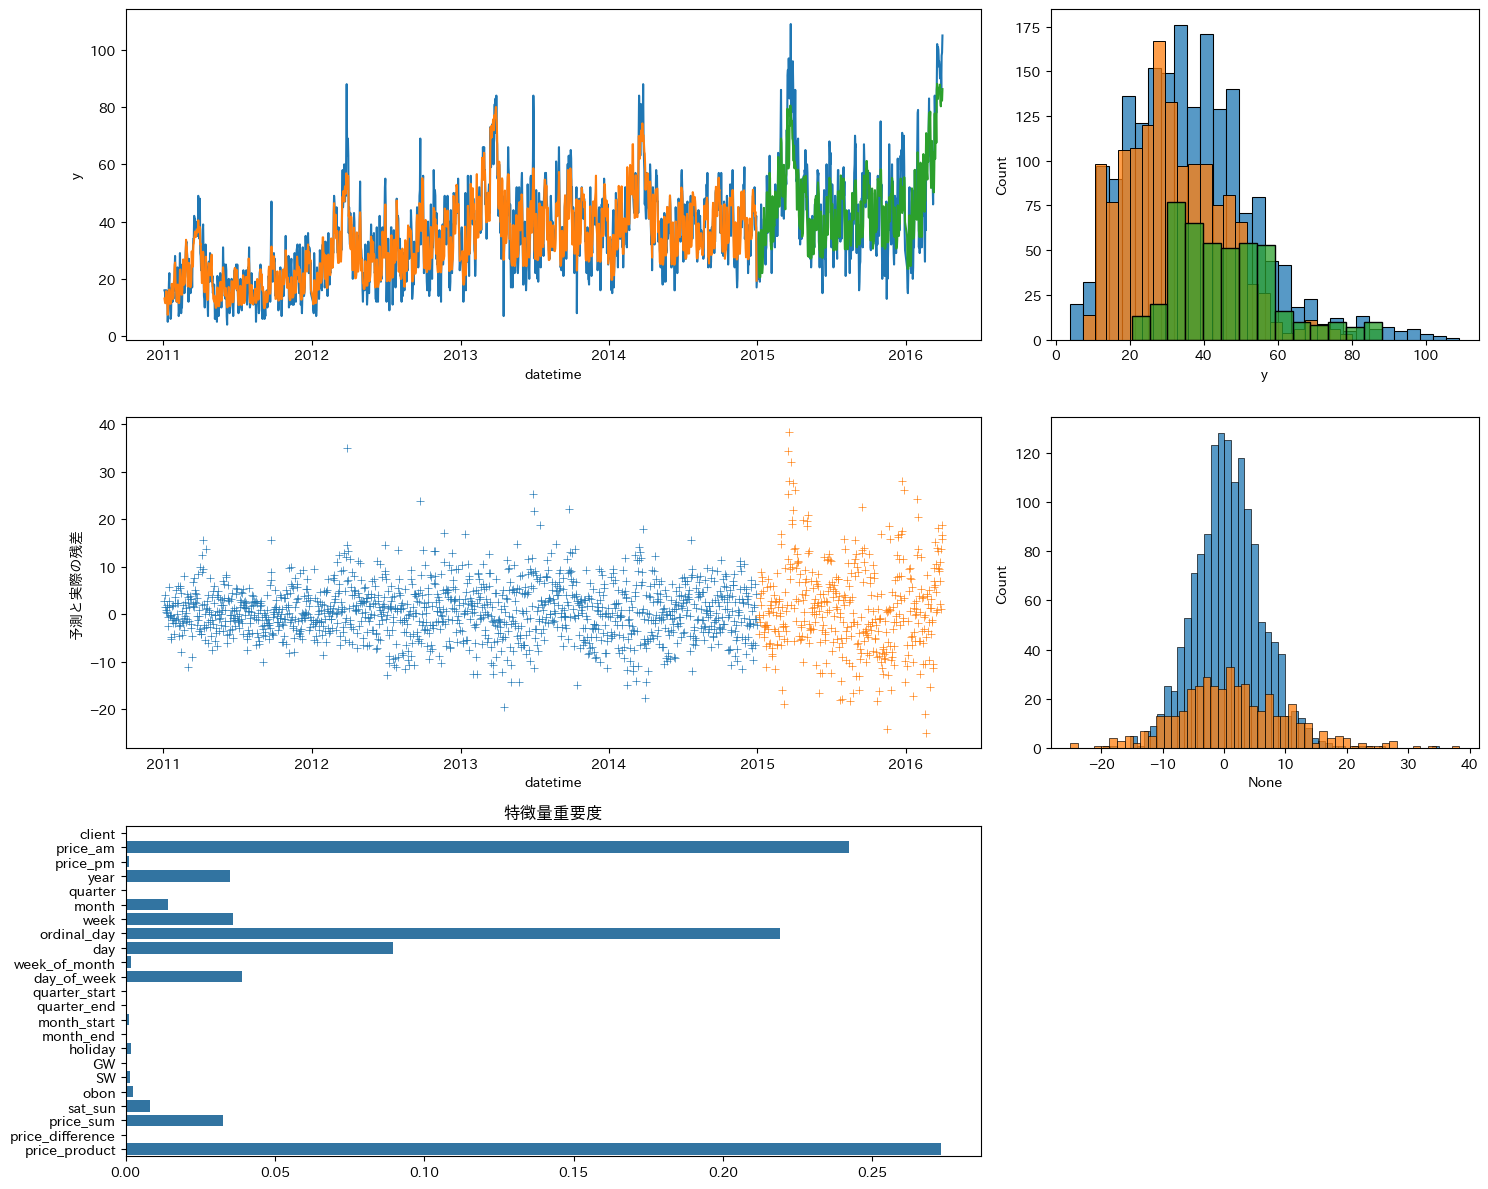

In [19]:
# 学習結果の可視化
fig, axes = plt.subplots(
    nrows=3, ncols=2,
    height_ratios=[1, 1, 1], width_ratios=[2, 1],
    figsize=(15, 12)
)

g_time_train = sns.lineplot(data = train_pandas, x="datetime", y="y", ax=axes[0, 0])
g_predict_train = sns.lineplot(data = train_temp, x="datetime", y=y_pred_train, ax=axes[0, 0])
g_predict_valid = sns.lineplot(data = valid_temp, x="datetime", y=y_pred_valid, ax=axes[0, 0])

g_time_hist_train = sns.histplot(data = train_pandas, x="y", ax=axes[0, 1])
g_predict_hist_train = sns.histplot(data = train_temp, x=y_pred_train, ax=axes[0, 1])
g_predict_hist_valid = sns.histplot(data = valid_temp, x=y_pred_valid, ax=axes[0, 1])

# 残差の確認
g_diff_train = sns.scatterplot(data = train_temp, x="datetime", y=train_temp["y"] - y_pred_train, marker = "+", ax=axes[1, 0])
g_diff_valid = sns.scatterplot(data = valid_temp, x="datetime", y=valid_temp["y"] - y_pred_valid, marker = "+", ax=axes[1, 0])
axes[1, 0].set_ylabel("予測と実際の残差")

g_hist_diff_train = sns.histplot(data = train_temp, x=train_temp["y"] - y_pred_train, bins=50, ax=axes[1, 1])
g_hist_diff_valid = sns.histplot(data = valid_temp, x=valid_temp["y"] - y_pred_valid, bins=50, ax=axes[1, 1])

# 特徴量重要度
g_importance = sns.barplot(x=model.feature_importances_, y=feature_columns, ax=axes[2, 0])
g_importance.set_title("特徴量重要度")

axes[2, 1].axis("off")

plt.tight_layout()

# ごちゃごちゃしやすい変数たちはここで一度全て削除しておく
del train_temp, valid_temp
del X_train, y_train, X_valid, y_valid
del y_pred_train, y_pred_valid

予測値のベースラインっぽいのが消えて、引っ越し数の低いところに対しても予測できるようになった！！  
ordinal_dayが強い。年始から数えて何日かなので、時期を表しているのだろう。  

ただ、今回の成果物のことを考えると…ピークへの追随が弱い。これでは、「特に繁忙期にどれくらいの需要が来そうか」の予測精度としては弱いか…？  
改善のためには、学習の際のスコアを変えてあげれば良いのだろうか？どんなものがあるだろうか？  
現状だと、MSEを使って学習をさせている。既に適切な指標を使っているはずではあるが…

# 提出データ出力

In [20]:
# 提出前に、全ての訓練データを使って学習させておく
X, y = train_pandas[feature_columns], train_pandas[target_column]
model = GradientBoostingRegressor(random_state = 1192).fit(X, y)

# 機械学習ライブラリと親和性の高いPandasに変換する
test_pandas = test.to_pandas().set_index("id")

# 説明変数の分割
X_test = test_pandas[feature_columns]

# 予測
y_pred_test = np.exp(model.predict(X_test) + test_pandas["y_ln_prophet"])

# 提出用DataFrame
submit = pl.DataFrame({
    "id": X_test.index.values,
    "y": y_pred_test.values
})

# 退避していた休業日のデータを結合
submit = pl.concat(
    [submit, test_close],
    how = "vertical_relaxed"
).sort("id")

# 提出ファイルを保存する
# submit.write_csv("../data/output/submit_add_features_gbt_default_prms.csv", include_header = False)

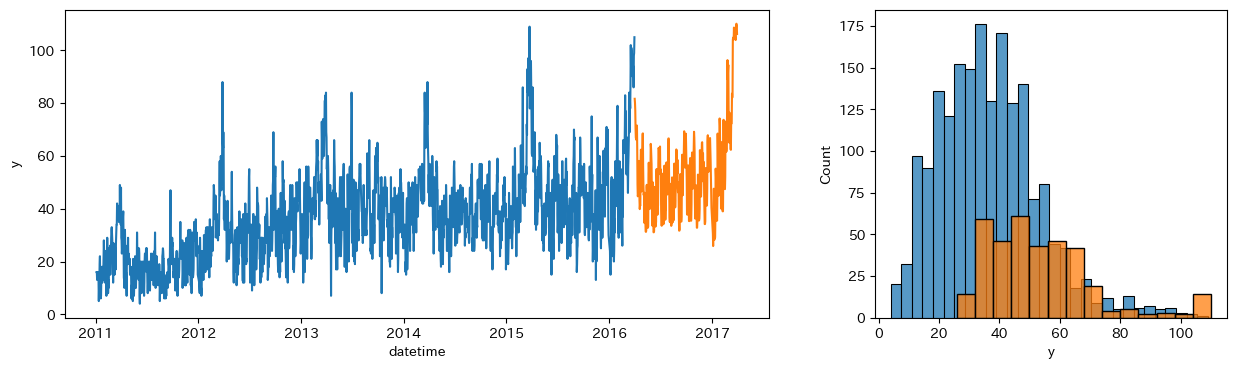

In [21]:
# テストデータに対する予測の可視化
fig, axes = plt.subplots(
    nrows=1, ncols=2,
    height_ratios=[1], width_ratios=[2, 1],
    figsize=(15, 4)
)

g_time_train = sns.lineplot(data = train_pandas, x="datetime", y="y", ax=axes[0])
g_time_test = sns.lineplot(data = test_pandas, x="datetime", y=y_pred_test, ax=axes[0])

g_hist_train = sns.histplot(data = train_pandas, x="y", ax=axes[1])
g_hist_test = sns.histplot(data = test_pandas, x=y_pred_test, ax=axes[1])

# メモ

今後は汎化性能を向上させたい。今は検証データのセットが一つだけ。訓練データに対するスコアと検証データに対する精度の差が激しい。  
KFold法みたいなやつを行って汎化性能を上げたいが、時系列予測なので分け方に気をつける必要がある。  
時系列予測だと、TimeSeriesSplitとかWalk Forwar Validationとかいうのが使われるらしい。  
他にも、パラメータチューニングも未実施なので、その辺りの取り組み余地はある  

ただ、250409 11:47 コンペのスコア：8.5537881であり、現時点で十分な精度がでているとも言える。  
これ以上の精度向上を求めるより、別の所(顧客の要件を満たす)に注力したほうが良いかも知れない

てかそういえば、あまり気にしてこなかったけど、この周期的な細かいギザギザは何によって生まれているんだろう？土日とか？  
確認してみても良いかも知れない

In [22]:
# 退避。特徴量の追加。trainとtestで重複したコードを書いていた頃

# train = (
#     train
#     # 日付の基本要素の追加
#     .with_columns([
#         # 年、四半期、月
#         pl.col("datetime").dt.year().alias("year"),
#         pl.col("datetime").dt.quarter().alias("quarter"),        
#         pl.col("datetime").dt.month().alias("month"),
#         # 年始から数えて何週目か
#         pl.col("datetime").dt.week().alias("week"),
#         # 年始から数えて何日目か
#         pl.col("datetime").dt.ordinal_day().alias("ordinal_day"),
#         # その月の何日か
#         pl.col("datetime").dt.day().alias("day"),        
#         # その月の何週目か
#         (pl.col("datetime").dt.day() // 7 + 1).alias("week_of_month"),
#         # 曜日
#         pl.col("datetime").dt.weekday().alias("day_of_week"),
#     ])
#     # 四半期はじめ・終わり、月はじめ・終わりのフラグ
#     .with_columns([
#         pl.when((pl.col("month").is_in([1, 4, 7, 10])) & (pl.col("day") == 1)).then(1)
#         .otherwise(0).alias("quarter_start"),
#         pl.when((pl.col("month").is_in([3, 6, 9, 12])) & (pl.col("datetime") == pl.col("datetime").dt.month_end())).then(1)
#         .otherwise(0).alias("quarter_end"),
#         pl.when(pl.col("day") == 1).then(1)
#         .otherwise(0).alias("month_start"),
#         pl.when(pl.col("datetime") == pl.col("datetime").dt.month_end()).then(1)
#         .otherwise(0).alias("month_end"),    
#     ])
#     # 価格の和・差・積
#     .with_columns([
#         (pl.col("price_am") + pl.col("price_pm")).alias("price_sum"),
#         (pl.col("price_am") - pl.col("price_pm")).alias("price_difference"),
#         # price = -1が欠損、price = 0は最安価格であった。price同士をそのまま乗算しまうと最安値のときに必ず積が0になってしまうので都合が良くない
#         # price + 1とすることでこれを回避する。なお、欠損がある場合は積は必ず0となる。これはこれで良いフラグかもしれない？
#         ((pl.col("price_am") + 1) * (pl.col("price_pm") + 1)).alias("price_product"),
#     ])
# )
# test = (
#     test
#     # 日付の基本要素の追加
#     .with_columns([
#         # 年、四半期、月
#         pl.col("datetime").dt.year().alias("year"),
#         pl.col("datetime").dt.quarter().alias("quarter"),        
#         pl.col("datetime").dt.month().alias("month"),
#         # 年始から数えて何週目か
#         pl.col("datetime").dt.week().alias("week"),
#         # 年始から数えて何日目か
#         pl.col("datetime").dt.ordinal_day().alias("ordinal_day"),
#         # その月の何日か
#         pl.col("datetime").dt.day().alias("day"),        
#         # その月の何週目か
#         (pl.col("datetime").dt.day() // 7 + 1).alias("week_of_month"),
#         # 曜日
#         pl.col("datetime").dt.weekday().alias("day_of_week"),
#     ])
#     # 四半期はじめ・終わり、月はじめ・終わりのフラグ
#     .with_columns([
#         pl.when((pl.col("month").is_in([1, 4, 7, 10])) & (pl.col("day") == 1)).then(1)
#         .otherwise(0).alias("quarter_start"),
#         pl.when((pl.col("month").is_in([3, 6, 9, 12])) & (pl.col("datetime") == pl.col("datetime").dt.month_end())).then(1)
#         .otherwise(0).alias("quarter_end"),
#         pl.when(pl.col("day") == 1).then(1)
#         .otherwise(0).alias("month_start"),
#         pl.when(pl.col("datetime") == pl.col("datetime").dt.month_end()).then(1)
#         .otherwise(0).alias("month_end"),    
#     ])
#     # 価格の和・差・積
#     .with_columns([
#         (pl.col("price_am") + pl.col("price_pm")).alias("price_sum"),
#         (pl.col("price_am") - pl.col("price_pm")).alias("price_difference"),
#         # price = -1が欠損、price = 0は最安価格であった。price同士をそのまま乗算しまうと最安値のときに必ず積が0になってしまうので都合が良くない
#         # price + 1とすることでこれを回避する。なお、欠損がある場合は積は必ず0となる。これはこれで良いフラグかもしれない？
#         ((pl.col("price_am") + 1) * (pl.col("price_pm") + 1)).alias("price_product"),
#     ])
# )